# Лабораторная работа 3: Computer Vision

В рамках лабораторной работы была выбрана задача классификации видов риса с использованием датасета с [Kaggle](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset). Для выполнения работы были выдвинуты несколько гипотез о признаках изображений, на основе которых строился классификатор.

### Гипотезы

1. **Гипотеза 1**: Рис сорта **Karacadag** является самым коротким.
2. **Гипотеза 2**: Рис сорта **Basmati** является самым длинным.
3. **Гипотеза 3**: Рис сорта **Basmati** является самым узким.
4. **Гипотеза 4**: Рис сорта **Ipsala** является самым широким.
5. **Гипотеза 5**: Рис сорта **Basmati** является самым ярким.
6. **Гипотеза 6**: Рис сорта **Arborio** является самым тусклым.
7. **Гипотеза 7**: Рис сорта **Karacadag** является наименее эллипсоидным.
8. **Гипотеза 8**: Рис сорта **Basmati** является наиболее эллипсоидным.
9. **Гипотеза 9**: Рис сорта **Ipsala** обладает наибольшей площадью зерна.
10. **Гипотеза 10**: Рис сорта **Jasmine** обладает наименьшей площадью зерна.

### Методы проверки гипотез

#### Гипотезы 1–4: Длина и ширина зерен
- Изображения переводятся в черно-белый формат для упрощения обработки.
- Каждое зерно выделяется в прямоугольник (bounding box), определяющий его длину и ширину.
- Выполняется статистический анализ средних размеров для сортов риса.

#### Гипотезы 5–6: Яркость
- Яркость зерен анализируется по среднему значению интенсивности пикселей.
- Результаты сравниваются между сортами с использованием дисперсионного анализа (ANOVA).

#### Гипотезы 7–8: Эллипсоидность
- Для каждого зерна определяются длина и ширина.
- Зерно сравнивается с эталонным эллипсом аналогичных размеров с использованием метрик, таких как расстояние Хаусдорфа.
- Проводится анализ для выявления сортов с минимальной и максимальной эллипсоидностью.

#### Гипотезы 9–10: Площадь
- Площадь зерна рассчитывается как количество пикселей внутри его контура.
- Средние значения площадей сортов сравниваются с использованием ANOVA.


### Проведение экспериментов

Для проверки гипотез были проведены эксперименты с анализом изображений, включающих выделение контура рисинок и анализ различных их признаков, таких как:

- Размер (длина, ширина, площадь)
- Форма (сравнение эллиптической формы)
- Яркость пикселей

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import f_oneway
from collections import Counter
import cv2

from src.features.feature_extraction import (
    RiceFeaturesExtraction, MeasureFeatureExtraction,
    BrightnessFeatureExtraction, SizeFeatureExtraction
)
from src.features.analyze_features import analyze_features
from src.features.model_validation import validate_model
from src.infer import infer_by_path, LABELS


In [3]:
DATASET_PATH = Path("Rice_Image_Dataset")
RESULTS_PATH = Path("results")
RESULTS_ANALYSIS_PATH = RESULTS_PATH / "results_analysis"
RESULTS_ANALYSIS_PATH.mkdir(parents=True, exist_ok=True)

In [18]:
# Извлечение признаков из изображений
def extract_features(dataset_path: Path):
    output_file = RESULTS_PATH / "features.csv"

    # Инициализация экстракторов
    measure_extractor = MeasureFeatureExtraction()
    brightness_extractor = BrightnessFeatureExtraction()
    size_extractor = SizeFeatureExtraction()
    feature_extractor = RiceFeaturesExtraction(
        measure_extractor, brightness_extractor, size_extractor
    )

    features = []
    for class_dir in dataset_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            for image_path in class_dir.glob("*.jpg"):
                try:
                    image = cv2.imread(str(image_path))
                    rice_features = feature_extractor.extract(image)
                    features.append({
                        "filename": image_path.name,
                        "class": class_name,
                        "width": rice_features.measure.width,
                        "height": rice_features.measure.height,
                        "brightness": rice_features.brightness.average_brightness,
                        "area": rice_features.size.area,
                    })
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Сохранение признаков в CSV
    df = pd.DataFrame(features)
    df.to_csv(output_file, index=False)
    print(f"Features saved to {output_file}")


Выполнение извлечения признаков (запустите при необходимости)

In [19]:
extract_features(DATASET_PATH)

Features saved to results/features.csv


**Анализ данных**

In [22]:
# Чтение данных
df = pd.read_csv(RESULTS_PATH / "features.csv")

# Функция для расчёта ANOVA и построения графиков
def analyze_feature(feature_name, df):
    classes = df["class"].unique()
    feature_data = [df[df["class"] == c][feature_name] for c in classes]
    f_stat, p_value = f_oneway(*feature_data)

    # Вычисление среднего значения для каждого класса
    means = df.groupby("class")[feature_name].mean()

    # Вывод средних значений
    print(f"Средние значения для признака '{feature_name}':")
    for cls, mean_value in means.items():
        print(f"- {cls}: {mean_value:.2f}")
    
    # Histogram
    sns.histplot(data=df, x=feature_name, hue="class", kde=True, bins=30)
    plt.title(f"Histogram of {feature_name.capitalize()} by Class")
    plt.savefig(RESULTS_ANALYSIS_PATH / f"{feature_name}_histogram.png")
    plt.show()

    print(f"ANOVA Test for {feature_name.capitalize()}: F={f_stat}, p={p_value}")

*1-2. Длина (короткий-длинный)*

Средние значения для признака 'height':
- Arborio: 138.75
- Basmati: 196.83
- Ipsala: 197.84
- Jasmine: 154.51
- Karacadag: 115.57


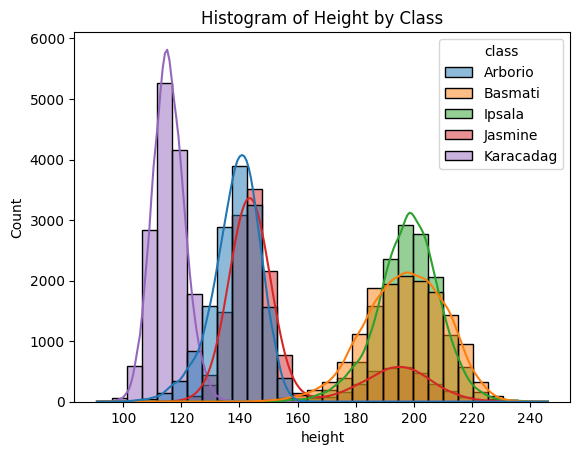

ANOVA Test for Height: F=108315.64229647449, p=0.0


In [23]:
analyze_feature("height", df)

Рис **Ipsala** самый длинный, его средняя длинна составляет 197.84 px. Его отрыв от риса Basmati всего 1.01 px.
\
Как и предполагалось, рис **Karacadag** самый короткий, его средняя длинна составляет 115.57 px.

*3-4. Ширина (узкий-широкий)*

Средние значения для признака 'width':
- Arborio: 70.19
- Basmati: 47.14
- Ipsala: 90.86
- Jasmine: 49.49
- Karacadag: 72.56


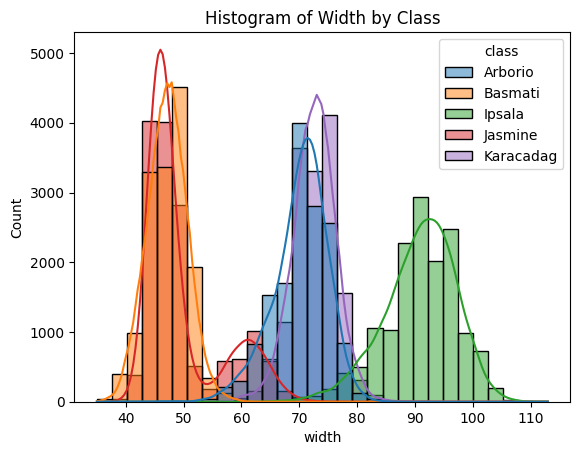

ANOVA Test for Width: F=185131.44221788688, p=0.0


In [24]:
analyze_feature("width", df)

Рис **Ipsala** самый широкий, его средняя ширина составляет 90.86. На втором месте с большим отрывом по ширине идет Karacadag со средней шириной 72.56 px.\
**Basmati** самый узкий, это соответствует нашей гипотезе.

*5-6. Яркость (яркий-блеклый)*

Средние значения для признака 'brightness':
- Arborio: 219.50
- Basmati: 237.21
- Ipsala: 237.43
- Jasmine: 225.04
- Karacadag: 225.59


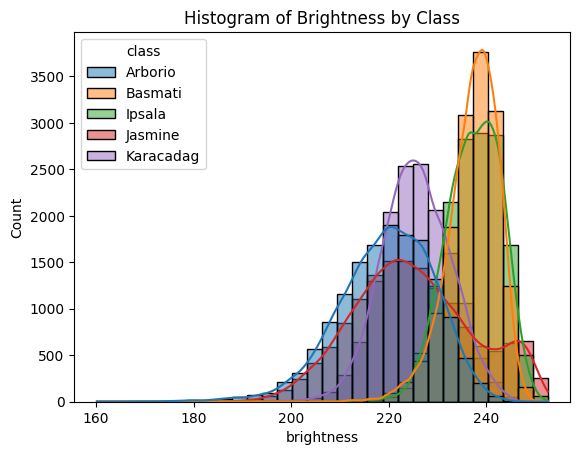

ANOVA Test for Brightness: F=13411.65287529894, p=0.0


In [28]:
analyze_feature("brightness", df)

Рис **Ipsala** и **Basmati** оказались самыми яркими, хотя Ipsala немного ярче Basmati: 237.43 против 237.21. Хотя отрыв и невелик, все же нельзя сказать, что риса Basmati самый яркий.
\
Как и предполагалось, рис **Arborio** самый тусклый, его средняя яркость составляет 219.50.

*7-8. Эллипсоидность*

Средние значения для признака 'aspect_ratio':
- Arborio: 1.98
- Basmati: 4.19
- Ipsala: 2.18
- Jasmine: 3.13
- Karacadag: 1.60


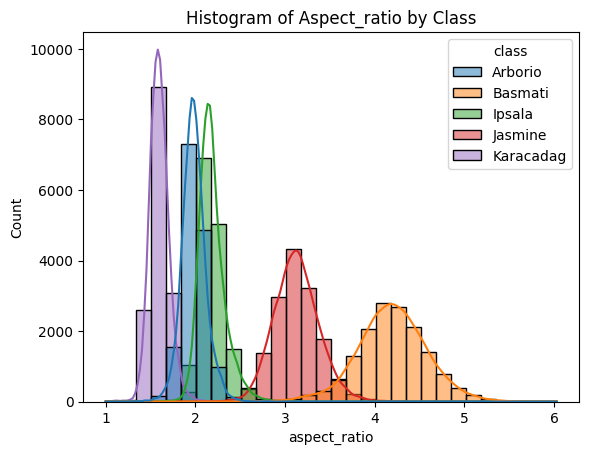

ANOVA Test for Aspect_ratio: F=315154.7625478043, p=0.0


In [26]:
df["aspect_ratio"] = df["height"] / df["width"]
analyze_feature("aspect_ratio", df)

Рис **Karacadag**, со средним значением 1.60 ближе к 1, которое характерно для круга. \
 **Basmati**, со средним значением 4.19 самое большое отношение длины к ширине.

*9-10. Площадь*

Средние значения для признака 'area':
- Arborio: 7379.33
- Basmati: 7371.62
- Ipsala: 13832.31
- Jasmine: 6108.92
- Karacadag: 6357.75


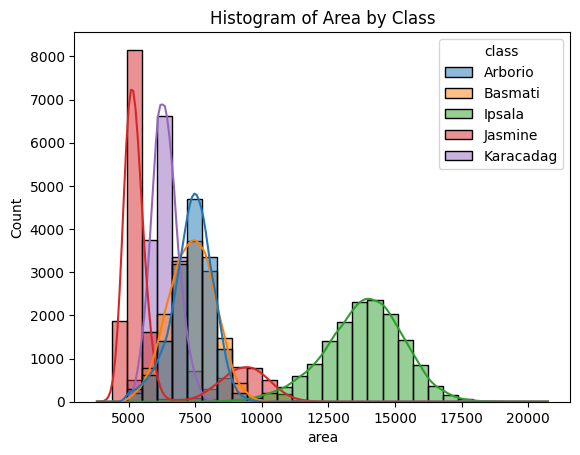

ANOVA Test for Area: F=110696.44056118901, p=0.0


In [27]:
analyze_feature("area", df)

Рис **Ipsala** самый крупный, средняя площадь его зерна составляет 13832.31 px².\
**Jasmine** обладает наименьшей средней площадью зерна: 6108.92 px².

### Оценка качества классификации

1. **Точность классификации (Accuracy)**  
   Показывает долю правильных предсказаний модели относительно общего числа объектов.

   **Формула**:
   $$
   \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
   $$
   - **TP** — истинно положительные предсказания.  
   - **TN** — истинно отрицательные предсказания.  
   - **FP** — ложные положительные предсказания.  
   - **FN** — ложные отрицательные предсказания.

   **Примечание**: Accuracy удобно использовать при сбалансированных классах.

2. **Полнота (Recall)**  
   Это то, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм.

   **Формула**:
   $$
   \text{Recall} = \frac{TP}{TP + FN}
   $$

   **Примечание**: Высокий Recall важен, когда приоритет — минимизировать пропуски.

3. **Точность (Precision)**  
   Это доля объектов, названными классификатором положительными и при этом действительно являющимися положительными.

   **Формула**:
   $$
   \text{Precision} = \frac{TP}{TP + FP}
   $$

   **Примечание**: Высокий Precision важен для уменьшения ложных срабатываний.

4. **F1-Score**  
   Гармоническое среднее между Precision и Recall.

   **Формула**:
   $$
   F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
   $$

   **Примечание**: F1-Score удобен, когда важны оба показателя и классы несбалансированы.


**Confusion matrix**

In [51]:
def calculate_metrics(confusion_matrix, labels):
    precision = {}
    recall = {}
    f1_score = {}
    accuracy = {}
    
    for label in labels:
        TP = confusion_matrix.loc[label, label]
        FP = confusion_matrix[label].sum() - TP
        FN = confusion_matrix.loc[label].sum() - TP
        TN = confusion_matrix.sum().sum() - (TP + FP + FN)
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score[label] = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label]) if (precision[label] + recall[label]) != 0 else 0
        accuracy[label] = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

        print(f"Class: {label}, Precision: {precision[label]:.3f}, Recall: {recall[label]:.3f}, F1: {f1_score[label]:.3f}, Accuracy: {accuracy[label]:.3f}")
    
    avg_precision = np.mean(list(precision.values()))
    avg_recall = np.mean(list(recall.values()))
    avg_f1 = np.mean(list(f1_score.values()))
    avg_accuracy = np.mean(list(accuracy.values()))
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy

def validate_model(dataset_path: Path):
    confusion_matrix = Counter()


    for class_name in LABELS.values():
        class_dir = dataset_path / class_name
        if not class_dir.is_dir():
            print(f"Class directory not found: {class_dir}")
            continue


        for image_path in class_dir.glob("*.jpg"):
            output = infer_by_path(image_path)
            predicted_class = max(enumerate(output), key=lambda x: x[1])[0]
            confusion_matrix[(class_name, LABELS[predicted_class])] += 1


    labels = list(LABELS.values())
    matrix = pd.DataFrame(0, index=labels, columns=labels)


    for (true_class, predicted_class), count in confusion_matrix.items():
        matrix.loc[true_class, predicted_class] = count

    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    plt.savefig(RESULTS_ANALYSIS_PATH / "confusion_matrix_all_classes.png")
    plt.show()




    avg_precision, avg_recall, avg_f1, avg_accuracy = calculate_metrics(matrix, LABELS.values())

    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1 Score: {avg_f1:.3f}")
    print(f"Average Accuracy: {avg_accuracy:.3f}")


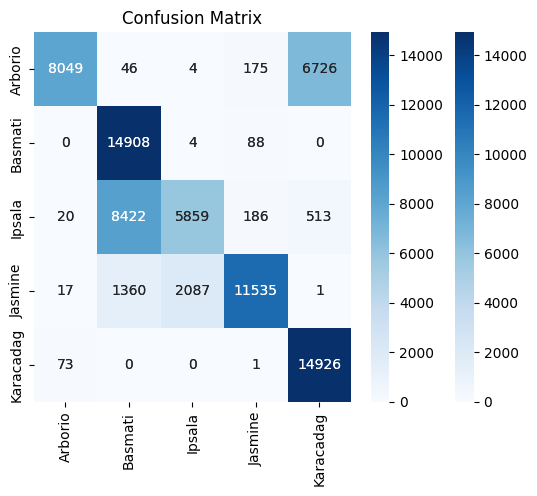

Class: Arborio, Precision: 0.987, Recall: 0.537, F1: 0.695, Accuracy: 0.906
Class: Basmati, Precision: 0.603, Recall: 0.994, F1: 0.750, Accuracy: 0.868
Class: Ipsala, Precision: 0.737, Recall: 0.391, F1: 0.510, Accuracy: 0.850
Class: Jasmine, Precision: 0.962, Recall: 0.769, F1: 0.855, Accuracy: 0.948
Class: Karacadag, Precision: 0.673, Recall: 0.995, F1: 0.803, Accuracy: 0.902
Average Precision: 0.792
Average Recall: 0.737
Average F1 Score: 0.723
Average Accuracy: 0.895


In [52]:
validate_model(DATASET_PATH)

## Результаты:

1. **Гипотеза 1**: Рис Karacadag самый короткий — **принята**. Средняя длина зерна сорта Karacadag составила 115.57 px, что является минимальным значением среди всех сортов.

2. **Гипотеза 2**: Рис Basmati самый длинный — **отвергнута**. Наибольшую среднюю длину зерна показал сорт Ipsala (197.84 px), опередив Basmati на 1.01 px.

3. **Гипотеза 3**: Рис Basmati самый узкий — **принята**. Средняя ширина зерна сорта Basmati составила 41.71 px, что является наименьшим значением среди всех сортов.

4. **Гипотеза 4**: Рис Ipsala самый широкий — **принята**. Средняя ширина зерна сорта Ipsala составила 90.86 px, что значительно больше, чем у других сортов.

5. **Гипотеза 5**: Рис Basmati самый яркий — **отвергнута**. Наибольшую среднюю яркость показал сорт Ipsala (237.43), опередив сорт Basmati (237.21) на 0.22.

6. **Гипотеза 6**: Рис Arborio самый тусклый — **принята**. Средняя яркость зерна сорта Arborio составила 219.50, что является минимальным значением среди всех сортов.

7. **Гипотеза 7**: Рис Karacadag наименее эллипсоидный — **принята**. Наименее эллипсоидным действительно оказался сорт Karacadag со средним отношением длины к ширине 1.60.

8. **Гипотеза 8**: Рис Basmati наиболее эллипсоидный — **принята**. Наиболее эллипсоидным оказался сорт Basmati, имеющий самое большое среднее отношение длины к ширине — 4.19.

9. **Гипотеза 9**: Рис Ipsala обладает наибольшей площадью зерна — **принята**. Средняя площадь зерна сорта Ipsala составила 13,832.31 px², что является наибольшим значением среди всех сортов.

10. **Гипотеза 10**: Рис Jasmine обладает наименьшей площадью зерна — **принята**. Средняя площадь зерна сорта Jasmine составила 6,108.92 px², что является наименьшим значением среди всех сортов.


### Классификатор показал следующие результаты:

- **Точность классификации(Accuracy)**: 89.5%
- **Полнота(Recall)**: 73.7%
- **Точность(Precision)**: 79.2%


#### Метрики для каждого класса:

- **Arborio**  
  - **Precision**: 0.987  
  - **Recall**: 0.537  
  - **F1-Score**: 0.695  
  - **Accuracy**: 0.906  

- **Basmati**  
  - **Precision**: 0.603  
  - **Recall**: 0.994  
  - **F1-Score**: 0.750  
  - **Accuracy**: 0.868  

- **Ipsala**  
  - **Precision**: 0.737  
  - **Recall**: 0.391  
  - **F1-Score**: 0.510  
  - **Accuracy**: 0.850  

- **Jasmine**  
  - **Precision**: 0.962  
  - **Recall**: 0.769  
  - **F1-Score**: 0.855  
  - **Accuracy**: 0.948  

- **Karacadag**  
  - **Precision**: 0.673  
  - **Recall**: 0.995  
  - **F1-Score**: 0.803  
  - **Accuracy**: 0.902  


### Вывод:
- Модель показала общую точность классификации (Accuracy) в 89.5%, что свидетельствует о ее способности правильно классифицировать большую часть объектов. Однако распределение метрик между классами указывает на варьируемость сложности распознавания различных сортов риса.
- Низкий Recall у класса **Ipsala** (39.1%) говорит о том, что модель часто пропускает объекты этого сорта, ошибочно классифицируя их как другие сорта.
- Для класса **Karacadag** высокий Recall (99.5%) показывает, что модель хорошо определяет этот сорт, но Precision на уровне 67.3% указывает на наличие большого количества ложных срабатываний.
- Среднее значение F1 Score в 72.3% указывает на сбалансированность между Precision и Recall в модели.